### Connecting to the drive to access the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing necessary libraries

In [ ]:
import warnings
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from PIL import ImageEnhance
import cv2

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay,f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD

### Unzipping the Data folder

In [ ]:
import zipfile

# Unzipping the images
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/AI_project/images.zip", 'r')
#zip_ref.extractall("/content/drive/MyDrive/AI_project/")
#zip_ref.close()

### Getting the paths to the Data folders

In [ ]:
import os

# The path to the images folder on google drive
path = '/content/drive/MyDrive/AI_project/eye-images'

normal = os.path.join(path,'1_normal/')
cataract = os.path.join(path,'2_cataract/')
glaucoma = os.path.join(path,'2_glaucoma/')
print("Number of Normal eye dataset", len(os.listdir(normal)))
print("Number of Cataract dataset", len(os.listdir(cataract)))
print("Number of Glaucoma dataset", len(os.listdir(glaucoma)))


Number of Normal eye dataset 300
Number of Cataract dataset 100
Number of Glaucoma dataset 101


## ***Data Exploration***

In [ ]:
## Load the file names from all directories
normal_images = os.listdir(normal)
cataract_images =  os.listdir(cataract)
glaucoma_images =  os.listdir(glaucoma)

In [ ]:
# Getting the image size
import cv2
img = cv2.imread('/content/drive/MyDrive/AI_project/eye-images/1_normal/NL_001.png')
img.shape

(1632, 2464, 3)

# ***Quality Control***

The following code chunk verifies the image integrity using the the Pillow package and provides flexibility to choose between sequential and parallel processing. Sequential processing is simple and suitable for small datasets, while parallel processing accelerates the validation of large datasets by utilizing multiple threads. Users can toggle between these options using a parameter, optimizing the process based on dataset size and system resources.

## *Data Augmentation*

To introduce variability in the dataset to help the models generalize better.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomBrightness, GaussianNoise, Rescaling, Resizing

augmentation = Sequential([

    Input(shape=(224, 224, 3)),
    RandomFlip("horizontal"),  # horizontal flips for anatomical realism
    RandomBrightness(factor=0.1),
    RandomRotation((-0.025, 0.025)),  # Small rotations to simulate slight capture variations
    RandomZoom(0.05),  # Minor zoom variations
    RandomTranslation(0.025, 0.025),  # Handle slight misalignments
    GaussianNoise(0.05),  # Add subtle noise for robustness
    Rescaling(1./255)  # Normalize pixel values to [0, 1]

])

In [ ]:
augmentation.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

(1, 224, 224, 3)


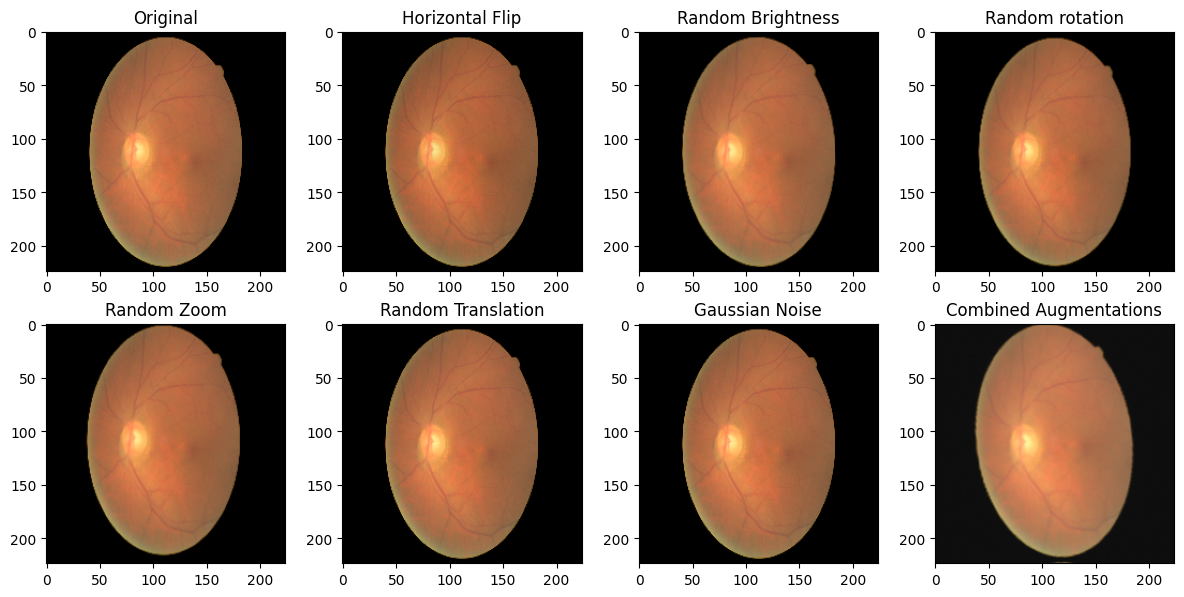

In [ ]:
# Load a sample image to test the augmentation steps -> must avoid distortions
img = tf.keras.preprocessing.image.load_img(os.path.join(cataract, cataract_images[0]), target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
print(img_array.shape)

# Apply each augmentation step individually and visualize
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()

# Original image
axs[0].imshow(img)
axs[0].set_title('Original')

# Random Flip - horizontal
augmented_img = augmentation.layers[1](img_array) # Applying RandomFlip using index 1
axs[1].imshow(tf.squeeze(augmented_img)/255.0)
axs[1].set_title('Horizontal Flip')

# Random Flip - vertical
augmented_img = augmentation.layers[2](img_array) # Applying Random Brightness using index 2
axs[2].imshow(tf.squeeze(augmented_img)/255.0)
axs[2].set_title('Random Brightness')

# Random Rotation
augmented_img = augmentation.layers[3](img_array) # Applying Random rotation using index 3
axs[3].imshow(tf.squeeze(augmented_img)/255.0)
axs[3].set_title('Random rotation')

# Random Zoom
augmented_img = augmentation.layers[4](img_array) # Applying RandomZoom using index 4
axs[4].imshow(tf.squeeze(augmented_img)/255.0)
axs[4].set_title('Random Zoom')

# Random Transalation
augmented_img = augmentation.layers[5](img_array) # Applying Random Translation using index 5
axs[5].imshow(tf.squeeze(augmented_img)/255.0)
axs[5].set_title('Random Translation')

# Gaussion Noise
augmented_img = augmentation.layers[6](img_array) # Applying Gaussian using index 6
axs[6].imshow(tf.squeeze(augmented_img))
axs[6].set_title('Gaussian Noise')

# Combined Augmentations
augmented_img = augmentation(img_array)
axs[7].imshow(tf.squeeze(augmented_img))
axs[7].set_title('Combined Augmentations')

# Show the plot
plt.tight_layout()
plt.show()

## Image Preprocessing

In [ ]:
import cv2  # used to read images

def load_images(directories, n_images=900000):
    """
    Reads in images and assigns class labels
    Parameters:
        directories: A list of the sub-directories
        n_images:    The maximum number of images to load from each directory
    Returns:
        images (numpy.ndarray) : Image data
        label (numpy.ndarray      : Labels of each image
    """
    images = []
    labels = []
    for label, sub_dir in enumerate(directories):
        num=1
        for file_name in os.listdir(sub_dir):
            if num > n_images:
                break
            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resizing to a smaller, consistent shape
                #gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                #images.append(gray_image)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
                num+=1
    return np.array(images), np.array(labels)

In [ ]:
images, labels = load_images([normal, cataract, glaucoma])

In [ ]:
images.shape

(501, 224, 224, 3)

## Splitting the data for training the model

In [ ]:
# Import required package
from sklearn.model_selection import train_test_split

# Spliting data into training + validation and test set (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [ ]:
from collections import Counter

print(Counter(y_train_val))
print(Counter(y_test))

Counter({0: 247, 1: 80, 2: 73})
Counter({0: 53, 2: 28, 1: 20})


## CNN Architecture

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)

In [ ]:
cnn_model2 = models.Sequential([
    Input(shape=(224, 224, 3)),
    augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten and Fully Connected Layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')
])

# Compiling the model with Adam optimizer
optimizer = Adam(learning_rate=1e-4) # Default value

cnn_model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # for multi-class classification
              metrics=['accuracy', 'categorical_accuracy'])

# Summary of the model
cnn_model2.summary()

In [ ]:
# Defining the CNN model function
def create_cnn_model():
    model = models.Sequential([
        Input(shape=(224, 224, 3)),
        augmentation,
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Flatten and Fully Connected Layer
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Using 5-Fold cross validation to select the model with the best performance.

In [ ]:
from sklearn.metrics import f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Initialize lists to store metrics
accuracy_per_fold = []
loss_per_fold = []
f1_per_fold = []

# Variables to track the best model
best_f1_score = -1
best_model = None

In [ ]:
# Cross-validation with K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fig, axs = plt.subplots(5, 2, figsize=(15, 15))  # 5 rows for 5 folds, 2 columns for loss and accuracy

for fold_no, (train_idx, val_idx) in enumerate(kf.split(X_train_val), 1):
    print(f"Fold {fold_no}...")
    X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
    y_train_fold, y_val_fold = y_train_val[train_idx], y_train_val[val_idx]

    # Compute class weights only on the training fold
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)

    model = create_cnn_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_fold, tf.keras.utils.to_categorical(y_train_fold, num_classes=3),
        validation_data=(X_val_fold, tf.keras.utils.to_categorical(y_val_fold, num_classes=3)),
        epochs=75,
        batch_size=32,
        #callbacks=[early_stopping],
        verbose=2,
        class_weight=class_weight_dict
    )

    scores = model.evaluate(X_val_fold, tf.keras.utils.to_categorical(y_val_fold, num_classes=3), verbose=0)
    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Generate predictions for the validation set
    predictions = model.predict(X_val_fold)
    predicted_labels = np.argmax(predictions, axis=1)

    # Compute the weighted F1 score
    fold_f1 = f1_score(y_val_fold, predicted_labels, average='weighted')
    f1_per_fold.append(fold_f1)
    print(f"Weighted F1 Score for Fold {fold_no}: {fold_f1:.4f}")

    # Check if this model has the best F1 score so far
    if fold_f1 > best_f1_score:
        best_f1_score = fold_f1
        best_model = model

    # Print classification report (assuming classes are labeled 0, 1, 2)
    print(f"Classification Report for Fold {fold_no}:")
    print(classification_report(y_val_fold, predicted_labels, target_names=['Normal', 'Cataract', 'Glaucoma']))

    axs[fold_no-1, 0].plot(history.history['loss'], label='Train Loss')
    axs[fold_no-1, 0].plot(history.history['val_loss'], label='Val Loss')
    axs[fold_no-1, 0].set_title(f'Fold {fold_no} Loss')
    axs[fold_no-1, 0].set_xlabel('Epoch')
    axs[fold_no-1, 0].set_ylabel('Loss')
    axs[fold_no-1, 0].legend()

    # Plot Accuracy for this fold
    axs[fold_no-1, 1].plot(history.history['accuracy'], label='Train Acc')
    axs[fold_no-1, 1].plot(history.history['val_accuracy'], label='Val Acc')
    axs[fold_no-1, 1].set_title(f'Fold {fold_no} Accuracy')
    axs[fold_no-1, 1].set_xlabel('Epoch')
    axs[fold_no-1, 1].set_ylabel('Accuracy')
    axs[fold_no-1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
print(f"Average Accuracy: {np.mean(accuracy_per_fold):.4f} ± {np.std(accuracy_per_fold):.4f}")
print(f"Average Loss: {np.mean(loss_per_fold):.4f} ± {np.std(loss_per_fold):.4f}")
print(f"Average Weighted F1 Score: {np.mean(f1_per_fold):.4f} ± {np.std(f1_per_fold):.4f}")

Average Accuracy: 0.7300 ± 0.0605
Average Loss: 0.6492 ± 0.1329
Average Weighted F1 Score: 0.7158 ± 0.0605


In [ ]:
best_model.save("/content/drive/MyDrive/AI_project/Models/cnn_classifier_crossVal.keras")

In [ ]:
# Further spliting training + validation into training and validation sets (e.g., 75% train, 25% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42
)

# Convert labels to categorical for training, validation, and test sets
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights_dict)

{0: 0.5614035087719298, 1: 1.592039800995025, 2: 1.693121693121693}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = best_model.fit(
    X_train,  # Input data
    y_train_cat,  # Categorical labels
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks = [early_stopping],
    class_weight=class_weights_dict
)

In [ ]:
# Using the model to make predictions on the testset
y_pred_prob = best_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [ ]:
y_pred  = y_pred_prob.argmax(axis=1)

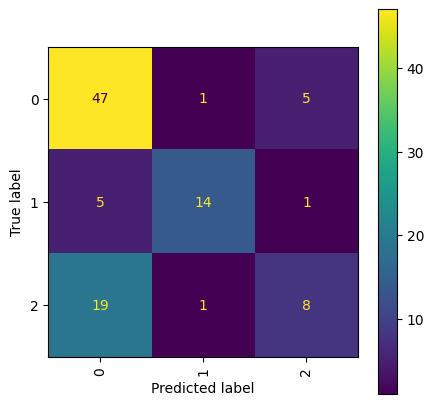

In [ ]:
cm  = confusion_matrix(y_test, y_pred)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

In [ ]:
from sklearn.metrics  import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.89      0.76        53
           1       0.88      0.70      0.78        20
           2       0.57      0.29      0.38        28

    accuracy                           0.68       101
   macro avg       0.70      0.62      0.64       101
weighted avg       0.68      0.68      0.66       101



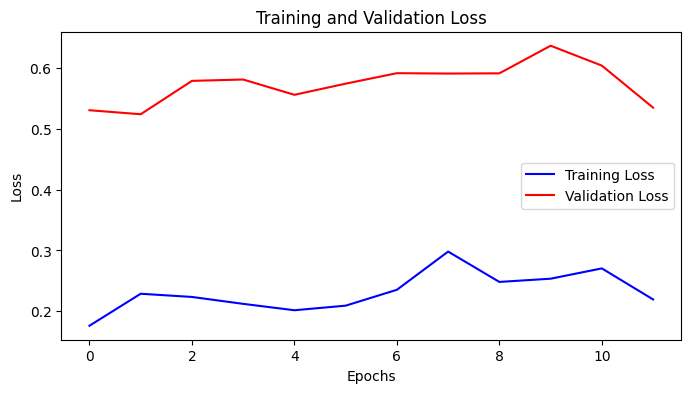

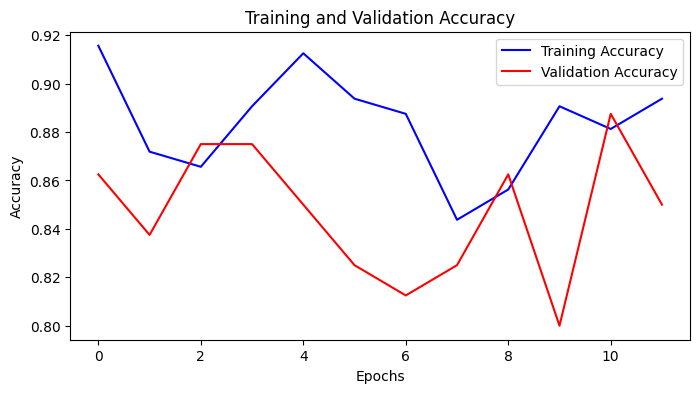

In [ ]:
epochs = history.epoch
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training and the validation accuracy and loss fluctuate over the training epochs. However, there are no signs of overfitting.

In [ ]:
from sklearn.metrics import roc_curve, auc

n_classes = y_test_cat.shape[1]  # Number of classes
n_classes

3

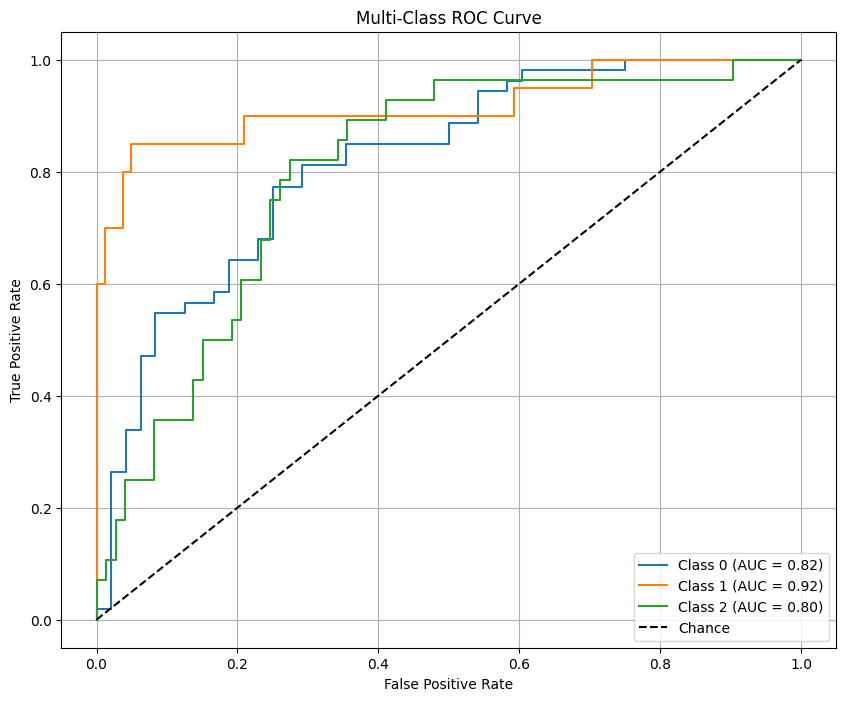

In [ ]:
# Initialize plot
plt.figure(figsize=(10, 8))

# Loop through each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])  # Compute FPR and TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC

    # Plot ROC curve for the current class
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the "chance" line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
!apt-get update
!apt-get install -y pandoc
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [3]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/AI_project/CustomCNN_CrossValidation.ipynb --allow-chromium-download

[NbConvertApp] Converting notebook /content/drive/MyDrive/AI_project/CustomCNN_CrossValidation.ipynb to pdf
[NbConvertApp] Support files will be in CustomCNN_CrossValidation_files/
[NbConvertApp] Making directory ./CustomCNN_CrossValidation_files
[NbConvertApp] Writing 86535 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 526335 bytes to /content/drive/MyDrive/AI_project/CustomCNN_CrossValidation.pdf
